# Implementing a Neural Network
---

This notebook is an implementation of the topics discussed in a blog post at [markus.ylisiurunen.com/blog/understanding-neural-networks](https://markus.ylisiurunen.com/blog/understanding-neural-networks).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

rc('animation', html='html5')

%matplotlib inline

## Numerical gradient checking
---

While we will be implementing the building blocks for our neural network, we will have to solve various gradients. In order to be able to verify our implementations, we would like to be able to somehow compare our implementations' output to the real gradient values. Luckily, we can easily do this by implementing a simple numerical gradient method.

In [2]:
def numerical_gradient(func, x, eps=1e-4):
    """
    Computes the numerical gradient of function 'func' w.r.t. 'x'.

    Args:
        func : A function of which gradient to compute.
        x    : The parameter to compute the gradient for. Must be a one-dimensional array.

    Returns:
        g : The gradient w.r.t. 'x'.
    """

    # mask for the epsilon
    e = np.zeros_like(x)

    # Initialise the gradient to zeros
    f = func(x)
    g = np.zeros((f.size, x.size))

    for i in range(len(x)):
        # Update the mask for epsilon
        e[:] = 0
        e[i] = 1

        # Compute the function outputs at points 'x + epsilon' and 'x - epsilon'
        f1, f2 = func(x + e * eps), func(x - e * eps)

        # Update the gradient w.r.t. the ith index in 'x'
        g[:, i] = (f1 - f2) / (2 * eps)

    return g

We can now verify our numerical gradient implementation with some function that we can easily inspect. Let's pick 

$$
f(x) = sin(x^2)
$$

as our test case.

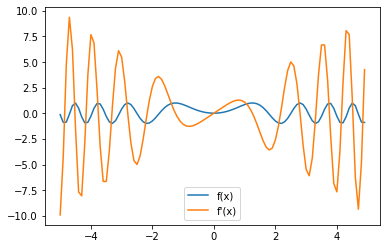

In [3]:
def test_numerical_gradient():
    func = lambda x: np.sin(x ** 2)

    x = np.arange(-5, 5, 0.1)
    y = np.array([func(x) for x in x.tolist()])

    dx = np.array([numerical_gradient(func, np.array([x])) for x in x.tolist()])

    plt.plot(x, y, label='f(x)')
    plt.plot(x, dx.flatten(), label='f\'(x)')

    plt.legend()

test_numerical_gradient()

We can visually verify that the gradient seems to be computed correctly. This will be enough for verifying our implementations later.

## Mean Square Error (MSE) loss function
---

Let's start off by implementing a class for the MSE loss function. The purpose of this is to be able to compute the loss w.r.t. some target output. MSE loss for a batch is defined as

$$
c = \frac{1}{m} \sum^{m} \sum_{i = 1}^{n} (y_i - \hat{y_i})^2
$$

and therefore the gradient w.r.t. $y$ is

$$
\frac{\partial c}{\partial y} = \frac{2}{m n} (y_i - \hat{y_i})
$$

In [4]:
class MSELoss:
    def forward(self, y, target):
        """
        Computes the MSE loss of each entry in the batch.

        Args:
            y      : The actual output from the neural network. Shape of (batch_size, out_features).
            target : The target output. Shape of (batch_size, out_features).

        Returns:
            c : The loss of each entry in the batch. Shape of (batch_size, 1).
        """

        # Note: Keep the differences for the gradient computation
        self.diff = y - target

        return np.sum(np.square(self.diff)) / self.diff.size

    def backward(self):
        """
        Computes the gradient of the loss w.r.t. 'y'.

        Returns:
            dy : The gradient of the loss w.r.t. 'y'. Shape of (batch_size, out_features).
        """

        return 2 / self.diff.size * self.diff

We can now write a test for making sure that our MSE loss is implemented correctly.

In [5]:
def test_MSELoss_backward():
    batch_size, out_features = 2, 3
    
    # Initialise the output and the target values for the test
    y = np.random.randn(batch_size, out_features)
    target = np.zeros((batch_size, out_features))

    # Compute the loss
    loss = MSELoss()
    loss.forward(y, target)

    # Compute the gradient
    dy = loss.backward()

    # Compute the numerical gradient
    dy_num = numerical_gradient(
        lambda y: loss.forward(y.reshape((batch_size, out_features)), target),
        y.flatten()
    )
    
    dy_num = dy_num[0].reshape((batch_size, out_features))

    # Compare the gradients
    print('Analytical gradient:\n', dy, '\n')
    print('Numerical gradient:\n', dy_num, '\n')

    assert np.allclose(dy, dy_num), 'Analytical and numerical results differ'

    print("Success!")

test_MSELoss_backward()

Analytical gradient:
 [[ 0.18699565 -0.15414829 -0.16480983]
 [ 0.31841441 -0.27402781 -0.57508441]] 

Numerical gradient:
 [[ 0.18699565 -0.15414829 -0.16480983]
 [ 0.31841441 -0.27402781 -0.57508441]] 

Success!


## Activation functions
---

The next thing we need are the activation functions. In order to compare the results, we will be implementing two different activation functions, ReLU and Tanh.

ReLU is defined as

$$
ReLu(z) = max(0, z)
$$

and Tanh is defined as

$$
Tanh(z) = tanh(z)
$$

In [6]:
class ReLU:
    def forward(self, z):
        """
        Args:
            z : Output from the previous layer. Shape of (batch_size, features).

        Returns:
            y : Input after the activation function. Shape of (batch_size, features).
        """

        # Note: Keep for gradients
        self.z = z

        return np.maximum(z, np.zeros(z.shape))

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. 'y'. Shape of (batch_size, features).

        Returns:
            dz : Gradient of the loss w.r.t. 'z'. Shape of (batch_size, features).
        """

        return np.where(self.z > 0, np.ones(self.z.shape), np.zeros(self.z.shape)) * dy

In [7]:
class Tanh:
    def forward(self, z):
        """
        Args:
            z : Output from the previous layer. Shape of (batch_size, features).

        Returns:
            y : Input after the activation function. Shape of (batch_size, features).
        """

        # Note: Keep for gradients
        self.z = z

        return np.tanh(z)

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. 'y'. Shape of (batch_size, features).

        Returns:
            dz : Gradient of the loss w.r.t. 'z'. Shape of (batch_size, features).
        """

        return (1 - np.tanh(self.z) ** 2) * dy

In [8]:
class Identity:
    def forward(self, z):
        """
        Args:
            z : Output from the previous layer. Shape of (batch_size, features).

        Returns:
            y : Input after the activation function. Shape of (batch_size, features).
        """

        # Note: Keep for gradients
        self.z = z

        return z

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. 'y'. Shape of (batch_size, features).

        Returns:
            dz : Gradient of the loss w.r.t. 'z'. Shape of (batch_size, features).
        """

        return dy

Let's now write a test for both of these activation functions to make sure that the gradients are computed correctly.

In [9]:
def test_activation_backward():
    # Note: The network is x --> activation --> MSELoss

    batch_size, out_features = 2, 3

    # Initialise the inputs and the targets
    x = np.random.randn(batch_size, out_features)
    target = np.zeros((batch_size, out_features))
    
    # Define the activation functions to test
    act_fns = [['ReLU', ReLU() ], ['Tanh', Tanh()], ['Identity', Identity()]]
    
    for act_fn in act_fns:
        act_fn_name, act_fn = act_fn[0], act_fn[1]

        # Instantiate the loss and do the forward pass
        loss = MSELoss()
        loss.forward(act_fn.forward(x), target)

        # Compute the gradients        
        dx = act_fn.backward(loss.backward())

        # Compute the numerical gradients        
        dx_num = numerical_gradient(
            lambda x: loss.forward(act_fn.forward(x.reshape((2, 3))), target),
            x.flatten()
        )

        dx_num = dx_num[0].reshape((2, 3))

        # Compare the gradients        
        print(act_fn_name, 'analytical gradient:\n', dx, '\n')
        print(act_fn_name, 'numerical gradient:\n', dx_num, '\n')

        assert np.allclose(dx, dx_num), 'Analytical and numerical results differ'

        print(act_fn_name, "was a success!\n")

test_activation_backward()

ReLU analytical gradient:
 [[0.04725267 0.92257669 0.42197149]
 [0.22370537 0.23125385 0.17218957]] 

ReLU numerical gradient:
 [[0.04725267 0.92257669 0.42197149]
 [0.22370537 0.23125385 0.17218957]] 

ReLU was a success!

Tanh analytical gradient:
 [[0.04600792 0.00517695 0.07757337]
 [0.12825948 0.12798943 0.12261448]] 

Tanh numerical gradient:
 [[0.04600792 0.00517695 0.07757337]
 [0.12825948 0.12798943 0.12261448]] 

Tanh was a success!

Identity analytical gradient:
 [[0.04725267 0.92257669 0.42197149]
 [0.22370537 0.23125385 0.17218957]] 

Identity numerical gradient:
 [[0.04725267 0.92257669 0.42197149]
 [0.22370537 0.23125385 0.17218957]] 

Identity was a success!



We are good to go for the next steps!

## Linear Layer
---

Next, probably the most interesting building block, the linear layer! It is defined as

$$
z = xW + b
$$

where $x$ is the (batch) input matrix of dimensions $m \text{x} n$, $W$ is the weight matrix and $b$ is the bias vector.

In [10]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Args:
            in_features  : Number of input features.
            out_features : Number of output features.
        """

        bound = np.sqrt(6 / (in_features + out_features))

        # Initialise the weights and biases
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        self.b = np.random.uniform(-bound, bound, (out_features))

        # Internal gradients for learning
        self.dW = None
        self.db = None

    def forward(self, x, W = None, b = None):
        """
        Args:
            x : Inputs of shape (batch_size, in_features).
            W : Optional weights of shape (out_features, in_features).
            b : Optional bias terms of shape (out_features).

        Returns:
            z : Outputs of shape (batch_size, out_features).
        """

        # Decide which weights and biases to use
        _W = self.W if W is None else W
        _b = self.b if b is None else b

        # Keep for gradient
        self.x = x

        return x @ _W.T + _b.T

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. 'y'. Shape of (batch_size, out_features).

        Returns:
            dx : Gradient of the loss w.r.t. 'x'. Shape of (batch_size, in_features).
        """
        
        # Compute the internal gradients
        self.dW = dy.T @ self.x
        self.db = np.sum(dy.T, axis=1)

        return dy @ self.W

    def save(self, id, folder):
        """
        Saves the linear layer's configuration to disk.

        Args:
            id     : An unique ID used for saving the model to disk.
            folder : Base path for the folder to save to.
        """

        np.save('{}/{}_W'.format(folder, id), self.W)
        np.save('{}/{}_b'.format(folder, id), self.b)

    def load(self, id, folder):
        """
        Loads the linear layer's configuration from disk.

        Args:
            id     : An unique ID used for loading the model from disk.
            folder : Base path for the folder to load from.
        """

        self.W = np.load('{}/{}_W'.format(folder, id))
        self.b = np.load('{}/{}_b'.format(folder, id))

Let's write the tests for each type of gradient.

In [11]:
def test_Linear_backward():
    batch_size, in_features, out_features = 3, 5, 3

    # Define the network
    loss_fn, act_fn, linear = MSELoss(), ReLU(), Linear(in_features, out_features)

    # Define the inputs and targets for the network
    x = np.random.randn(batch_size, in_features)
    target = np.zeros((batch_size, out_features))

    # Take a copy of the randomly initialised weights and biases for the numerical gradient
    W = linear.W.copy()
    b = linear.b.copy()
    
    # Do forward and backward passes
    c = loss_fn.forward(act_fn.forward(linear.forward(x)), target)
    dx = linear.backward(act_fn.backward(loss_fn.backward()))

    # ---

    # dx
    dx_num = numerical_gradient(
        lambda x: loss_fn.forward(
            act_fn.forward(
                linear.forward(x.reshape((batch_size, in_features)))
            ),
            target
        ),
        x.flatten()
    )
    
    dx_num = dx_num[0].reshape((batch_size, in_features))
    
    print('Analytical dx:\n', dx, '\n')
    print('Numerical dx:\n', dx_num, '\n')

    assert np.allclose(dx, dx_num), 'Analytical and numerical dx differ'

    print('Success for dx!\n')

    # ---

    # dW
    dW_num = numerical_gradient(
        lambda W: loss_fn.forward(
            act_fn.forward(
                linear.forward(x, W.reshape((out_features, in_features)), b)
            ),
            target
        ),
        W.flatten()
    )
    
    dW_num = dW_num[0].reshape((out_features, in_features))

    print('Analytical dW:\n', linear.dW, '\n')
    print('Numerical dW:\n', dW_num, '\n')

    assert np.allclose(linear.dW, dW_num), 'Analytical and numerical dW differ'

    print('Success for dW!\n')

    # ---

    # db
    db_num = numerical_gradient(
        lambda b: loss_fn.forward(act_fn.forward(linear.forward(x, W, b)), target),
        b
    )[0]

    print('Analytical db:\n', linear.db, '\n')
    print('Numerical db:\n', db_num, '\n')

    assert np.allclose(linear.db, db_num), 'Analytical and numerical db differ'

    print('Success for db!')

test_Linear_backward()

Analytical dx:
 [[ 0.00820231  0.05044731  0.09133918  0.03257312 -0.05906834]
 [ 0.13987885  0.14429172  0.24388194  0.15230978 -0.10007148]
 [ 0.          0.          0.          0.          0.        ]] 

Numerical dx:
 [[ 0.00820231  0.05044731  0.09133918  0.03257312 -0.05906834]
 [ 0.13987885  0.14429172  0.24388194  0.15230978 -0.10007148]
 [ 0.          0.          0.          0.          0.        ]] 

Success for dx!

Analytical dW:
 [[0.10086243 0.14310943 0.04059226 0.1343986  0.05534252]
 [0.36614045 0.16283945 0.12087158 0.13176057 0.04641794]
 [0.         0.         0.         0.         0.        ]] 

Numerical dW:
 [[0.10086243 0.14310943 0.04059226 0.1343986  0.05534252]
 [0.36614045 0.16283945 0.12087158 0.13176057 0.04641794]
 [0.         0.         0.         0.         0.        ]] 

Success for dW!

Analytical db:
 [0.15038718 0.39941553 0.        ] 

Numerical db:
 [0.15038718 0.39941553 0.        ] 

Success for db!


We are now ready to train the network!

## Constructing the Neural Network
---

In [12]:
class MLP:
    def __init__(self, name, in_features, hidden_sizes, out_features, activation_fn):
        """
        Args:
            name          : Name of the network.
            in_features   : Number of input features.
            hidden_sizes  : An array of hidden layer sizes.
            out_features  : Number of output features.
            activation_fn : Activation function to use for each layer.
        """

        self.name = name

        # Initialise the first hidden layer
        self.modules = [
            Linear(in_features, hidden_sizes[0]),
            activation_fn()
        ]
        
        # Initialise the rest of the hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.modules.append(Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            self.modules.append(activation_fn())

        # Initialise the output layer
        self.modules.append(Linear(hidden_sizes[-1], out_features))

    def forward(self, x):
        """
        Do the forward pass.

        Args:
            x : Inputs of shape (batch_size, in_features).

        Returns:
            y : Outputs of shape (batch_size, out_features).
        """

        y = x
        
        for layer in self.modules:
            y = layer.forward(y)
        
        return y

    def backward(self, dy):
        """
        Do the backward pass.

        Args:
            dy : Gradient of the loss w.r.t. 'y'. Shape of (batch_size, out_features).

        Returns:
            dx : Gradient of the loss w.r.t. 'x'. Shape of (batch_size, in_features).
        """

        dx = dy
        
        for i in range(len(self.modules) - 1, -1, -1):
            dx = self.modules[i].backward(dx)

        return dx

    def save(self):
        """
        Save the network to disk.
        """

        for i, module in enumerate(self.modules):
            if hasattr(module, 'W'):
                module.save(self.get_id(i), self.get_folder())

    def load(self):
        """
        Load the network from disk.
        """

        for i, module in enumerate(self.modules):
            if hasattr(module, 'W'):
                module.load(self.get_id(i), self.get_folder())

    def get_folder(self):
        return './model'

    def get_id(self, layer_index):
        return '{}_layer-{}'.format(self.name, layer_index)

Let's test the network by plotting its function and then computing the gradient for that function. We should be able to visually verify the gradient.

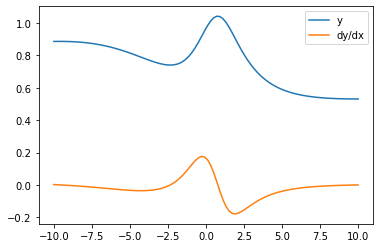

In [13]:
def test_mlp():
    batch_size = 100
    
    # Define the network
    mlp = MLP('test', 1, [10, 20], 1, Tanh)

    # Define the inputs and compute the network's outputs
    x = np.linspace(-10, 10, batch_size)
    y = mlp.forward(x.reshape((batch_size, 1))).flatten()

    # Compute the gradient
    dy = np.ones((batch_size, 1))
    dx = mlp.backward(dy).flatten()

    # Plot the output and its gradient
    plt.plot(x, y, label='y')
    plt.plot(x, dx, label='dy/dx')

    plt.legend()

test_mlp()

Seems about right!

## Training for a non-linear function
---

Now that we are able to define a neural network and it seems to work properly, we can finally train it for some data set! Let's begin by defining our toy dataset.

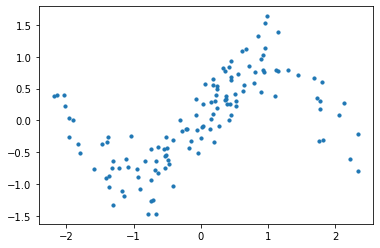

In [14]:
def generate_toy_data(n, plot = False):
    # First, let's generate a random set of x values
    x = np.sort(np.random.randn(n, 1), axis=0)

    # Let's compute the targets (with Gaussian noise)
    targets = np.sin(x * np.pi / 2) + 0.3 * np.random.randn(n, 1)

    if plot:
        plt.scatter(x, targets, s=10)

    return x, targets

generate_toy_data(128, True);

Now that we have our data, let's train our network!

In [15]:
def train_toy_network(activation_fn, epochs = 250):
    # Define our data
    x, targets = generate_toy_data(128)

    # Define parameters for training
    learning_rate = 0.075

    # Define our network and loss
    net = MLP("toy", 1, [20, 20], 1, activation_fn)
    loss = MSELoss()

    # Define the outputs after each epoch
    outputs = np.ndarray((epochs, x.size))

    for i in range(epochs):
        # Forward pass
        y = net.forward(x)
        c = loss.forward(y, targets)

        # Backward pass
        dy = loss.backward()
        dx = net.backward(dy)

        # Gradient descent update
        learning_rate *= 0.998

        for module in net.modules:
            if hasattr(module, 'W'):
                module.W = module.W - module.dW * learning_rate
                module.b = module.b - module.db * learning_rate

        # Append the outputs
        outputs[i, :] = net.forward(x).flatten()

    return (x, targets), net, outputs

toy_net_identity = train_toy_network(Identity)
toy_net_tanh = train_toy_network(Tanh)
toy_net_relu = train_toy_network(ReLU)

We can now visualise the learning process by animating the learning process.

In [16]:
def visualise_learning(data, outputs):
    fig, ax = plt.subplots(1)

    ax.scatter(data[0], data[1], s=10)
    net_line, = ax.plot([], [], 'r-')

    def animate(i):
        net_line.set_data(data[0], outputs[i, :])
    
    return animation.FuncAnimation(
        fig,
        animate,
        frames=outputs.shape[0],
        interval=40
    )

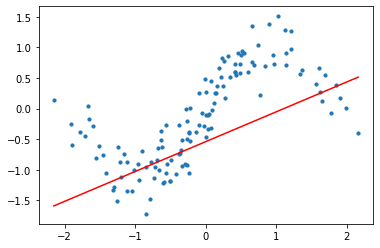

In [17]:
anim = visualise_learning(toy_net_identity[0], toy_net_identity[2])
anim

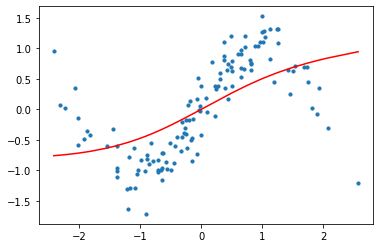

In [18]:
anim = visualise_learning(toy_net_tanh[0], toy_net_tanh[2])
anim

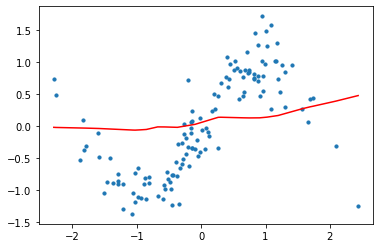

In [19]:
anim = visualise_learning(toy_net_relu[0], toy_net_relu[2])
anim

We can see how the network learns in the animations above. With the identity activation function, we will end up with a line as the combination of linear functions is still a linear function. However, with `Tanh` and `ReLU`, we end up with much more interesting results.

## Training for MNIST
---

The next step is to train the network for the MNIST dataset. It consists of tens of thousands of hand-written numbers that we are attempting to recognize with our network.

Let's start off with loading the dataset in memory.

In [20]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(np.int)

To familiarize ourselves with the dataset, let's plot 9 of the first images just to get an idea of what we are dealing with.

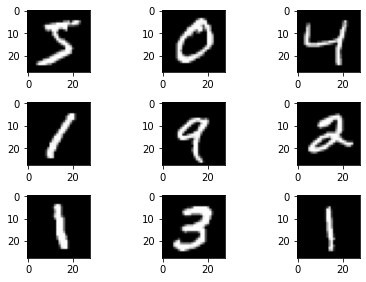

In [21]:
fig, axs = plt.subplots(3, 3)

for i, axi in enumerate(axs.flat):
    img = X[i, :].reshape((28, 28)) / 255
    axi.imshow(img, cmap="gray")

plt.tight_layout(True)
plt.show()

As we can see, we have a nicely normalized set of hand-written letters. In fact, we have 70k of these and each image is 28 pixels by 28 pixels containing only a single channel (grayscale).

Now, our task is to somehow be able to teach our neural network to be able to classify the hand-written digits. For these types of one-hot classification tasks, MSE loss is not ideal but rather cross-entropy with softmax is widely used. We won't go into detail why this is the case but rather just implement it below.

If you are interested in reading more about the topic, this article was quite good [Understand Cross Entropy Loss in Minutes](https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a)

In [22]:
def softmax(x):
    """
    Applies the Softmax activation function to 'x'.

    Args:
        x : Inputs of shape (batch_size, n_classes).

    Returns:
        z : Inputs after the Softmax function is applied. Shape of (batch_size, n_classes).
    """

    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape((-1, 1))

class CrossEntropy:
    def forward(self, z, target):
        """
        The loss network is z --> y = softmax(z) --> c = CrossEntropy(y).

        Args:
            z      : Outputs from the network's last layer. Shape of (batch_size, n_classes).
            target : Target classes (one-hot encoded). Shape of (batch_size, n_classes).

        Returns:
            c : The cross-entropy loss.
        """

        # Pass through the softmax activation function
        y = softmax(z)

        # Keep the differences for the gradient
        self.grad = y - target

        return -1 * np.mean(target * np.log(y + 1e-9))

    def backward(self):
        """
        Returns:
            dz : Gradient of the loss w.r.t. 'z'. Shape of (batch_size, n_classes).
        """

        return self.grad / self.grad.size

In [23]:
def test_CrossEntropyWithSoftmax_backward():
    batch_size, n_classes = 5, 3

    # Generate the output from the network
    y = np.random.uniform(0, 1, (batch_size, n_classes))

    # Generate the one-hot encoded targets
    indices = np.random.randint(0, n_classes, (batch_size, 1))

    target = np.zeros((batch_size, n_classes))
    target[np.arange(batch_size), indices[:, 0]] = 1

    # Compute the loss
    loss = CrossEntropy()
    loss.forward(y, target)

    # Compute the gradients
    dy = loss.backward()

    dy_num = numerical_gradient(
        lambda y: loss.forward(y.reshape((batch_size, n_classes)), target),
        y.flatten()
    )[0].reshape((batch_size, n_classes))

    print('Analytical:\n', dy, '\n')
    print('Numerical:\n', dy_num, '\n')

    assert np.allclose(dy, dy_num), 'Analytical and numerical gradients differ'

    print('Success!')

test_CrossEntropyWithSoftmax_backward()

Analytical:
 [[ 0.02492915 -0.05047277  0.02554361]
 [ 0.01806289  0.02534489 -0.04340777]
 [-0.0432432   0.02638628  0.01685692]
 [ 0.01767098  0.01769466 -0.03536564]
 [ 0.02042761 -0.04277309  0.02234548]] 

Numerical:
 [[ 0.02492915 -0.05047277  0.02554361]
 [ 0.01806289  0.02534489 -0.04340777]
 [-0.0432432   0.02638628  0.01685692]
 [ 0.01767098  0.01769466 -0.03536564]
 [ 0.02042761 -0.04277309  0.02234548]] 

Success!


Now that we have our Cross-Entropy loss ready to go, we can start training the network. The first thing we need to do before training is splitting our data into training and test sets.

In [24]:
n_train = 60000
n_test = X.shape[0] - n_train

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=n_train,
    test_size=n_test
)

print('Training set contains {} samples'.format(X_train.shape[0]))
print('Testing set contains {} samples'.format(X_test.shape[0]))

Training set contains 60000 samples
Testing set contains 10000 samples


Finally, we can train the network!

In [25]:
def compute_accuracy(z, target):
    """
    Computes the accuracy of the predictions.

    Args:
        z      : Outputs from the network. Shape of (n_samples, n_classes).
        target : Target classes. Shape of (n_samples, 1).

    Returns:
        accuracy : The accuracy of the predictions (0-1).
    """

    predicted_classes = np.argmax(z, axis=1)
    return np.sum(predicted_classes == target) / target.shape[0]

def train_mnist_neural_network(net, n_epochs, get_learning_rate):
    """
    Trains the network 'net' for 'n_epochs' epochs with the learning rate of 'learning_rate'.

    Args:
        net               : The neural network instance.
        n_epochs          : Number of epochs to take.
        get_learning_rate : A function which returns the learning rate for epoch 'i'.

    Returns:
        (loss, train_accuracy, test_accuracy)
    """

    batch_size = 50
    n_batches = int(n_train / batch_size)

    loss = CrossEntropy()

    # Define the outputs
    output_loss = []
    output_train_accuracy = []
    output_test_accuracy = []

    for i in range(n_epochs):
        should_print = (i % 5) == 0

        if should_print:
            print('Starting epoch {}'.format(i))

        learning_rate = get_learning_rate(i)
        epoch_loss = 0

        for batch_i in range(n_batches):
            # Select the indices of the training samples for this batch
            batch_indices = np.arange(
                batch_i * batch_size,
                batch_i * batch_size + batch_size
            )

            # Select and scale the batch images
            X_batch = X_train[batch_indices, :]
            X_batch = X_batch / 255

            # Select and one-hot encode the targets
            y_batch = np.zeros((batch_size, 10))
            y_batch[np.arange(batch_size), y_train[batch_indices].astype(np.int)] = 1

            # Forward pass
            z = net.forward(X_batch)
            c = loss.forward(z, y_batch)

            # Append the batch loss to the epoch loss
            epoch_loss += c

            # Backward pass
            dz = loss.backward()
            dx = net.backward(dz)

            # Gradient descent update
            for module in net.modules:
                if hasattr(module, 'W'):
                    module.W = module.W - module.dW * learning_rate
                    module.b = module.b - module.db * learning_rate

        # Compute the epoch loss
        epoch_loss = epoch_loss / (n_train / batch_size)
        output_loss.append(epoch_loss)

        if should_print:
            print('Loss for epoch {} was {:.4f}'.format(i, epoch_loss))

        # Compute the accuracy on the training and test sets
        train_accuracy = compute_accuracy(net.forward(X_train / 255), y_train)
        test_accuracy = compute_accuracy(net.forward(X_test / 255), y_test)

        output_train_accuracy.append(train_accuracy)
        output_test_accuracy.append(test_accuracy)

        if should_print:
            print('Train accuracy for epoch {} was {:.2f}%'.format(i, train_accuracy * 100))
            print('Test accuracy for epoch {} was {:.2f}%'.format(i, test_accuracy * 100))
            print('==========')

    return output_loss, output_train_accuracy, output_test_accuracy

In [26]:
net = MLP('mnist', 784, [512, 256], 10, activation_fn=ReLU)

In [27]:
def get_learning_rate(i):
    # Epochs 0-10: 0.001 --> 0.0075
    if i < 10:
        return 0.001 + i * (0.0075 - 0.001) / 10

    # Epochs 10-20: 0.0075 --> 0.025
    if 10 <= i < 20:
        return 0.0075 + (i - 10) * (0.025 - 0.0075) / 10

    # Epochs 20-60: 0.025 --> 0.125
    return 0.025 + (i - 20) * (0.125 - 0.025) / 40

mnist_loss, mnist_train_accuracy, mnist_test_accuracy = train_mnist_neural_network(
    net=net,
    n_epochs=60,
    get_learning_rate=get_learning_rate
)

Starting epoch 0
Loss for epoch 0 was 0.2305
Train accuracy for epoch 0 was 18.13%
Test accuracy for epoch 0 was 18.05%
Starting epoch 5
Loss for epoch 5 was 0.1173
Train accuracy for epoch 5 was 81.30%
Test accuracy for epoch 5 was 82.01%
Starting epoch 10
Loss for epoch 10 was 0.0504
Train accuracy for epoch 10 was 87.73%
Test accuracy for epoch 10 was 87.81%
Starting epoch 15
Loss for epoch 15 was 0.0344
Train accuracy for epoch 15 was 90.76%
Test accuracy for epoch 15 was 90.72%
Starting epoch 20
Loss for epoch 20 was 0.0270
Train accuracy for epoch 20 was 92.57%
Test accuracy for epoch 20 was 92.29%
Starting epoch 25
Loss for epoch 25 was 0.0218
Train accuracy for epoch 25 was 94.09%
Test accuracy for epoch 25 was 93.70%
Starting epoch 30
Loss for epoch 30 was 0.0173
Train accuracy for epoch 30 was 95.31%
Test accuracy for epoch 30 was 94.83%
Starting epoch 35
Loss for epoch 35 was 0.0136
Train accuracy for epoch 35 was 96.44%
Test accuracy for epoch 35 was 95.72%
Starting epoch 4

Let's plot the loss function

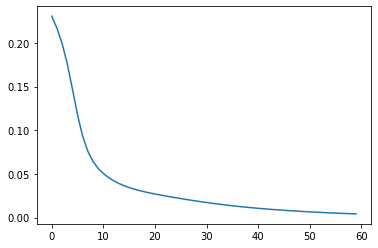

In [28]:
plt.plot(np.arange(0, len(mnist_loss), 1), mnist_loss)

And similarly let's plot the training and testing accuracy

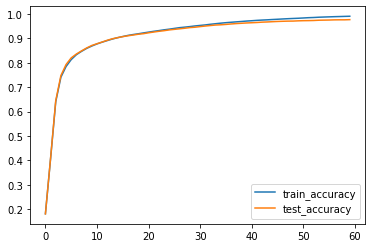

In [29]:
plt.plot(np.arange(0, len(mnist_loss), 1), mnist_train_accuracy, label='train_accuracy')
plt.plot(np.arange(0, len(mnist_loss), 1), mnist_test_accuracy, label='test_accuracy')

plt.legend()

Finally, we can save the model to disk for later use.

In [30]:
net.save()